# Benchmark MPNN model on the Tox21 dataset (with Masked Loss)

In [4]:
import sys
sys.path.append('../../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


from molgraph.chemistry.benchmark import configs
from molgraph.chemistry.benchmark import tf_records
from molgraph.chemistry import datasets
from molgraph.losses import MaskedBinaryCrossentropy

### Define molecular graph encoder

In [8]:
from molgraph.chemistry import features
from molgraph.chemistry import AtomFeaturizer, BondFeaturizer
from molgraph.chemistry import MolecularGraphEncoder

atom_encoder = AtomFeaturizer([
    features.Symbol(),
    features.Hybridization(),
    features.FormalCharge(),
    features.TotalNumHs(),
    features.TotalValence(),
    features.NumRadicalElectrons(),
    features.Degree(),
    features.ChiralCenter(),
    features.Aromatic(),
    features.Ring(),
    features.Hetero(),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.CIPCode(),
    features.ChiralCenter(),
    features.RingSize(),
    features.Ring(),
    features.CrippenLogPContribution(),
    features.CrippenMolarRefractivityContribution(),
    features.TPSAContribution(),
    features.LabuteASAContribution(),
    features.GasteigerCharge(),
])

bond_encoder = BondFeaturizer([
    features.BondType(),
    features.Conjugated(),
    features.Rotatable(),
    features.Ring(),
    features.Stereo(),
])

encoder = MolecularGraphEncoder(
    atom_encoder,
    bond_encoder,
    positional_encoding_dim=16,
    self_loops=False
)

### Obtain dataset and molecular graph

In [9]:
tox21 = datasets.get('tox21')

x_train = encoder(tox21['train']['x'])
y_train = tox21['train']['y']

x_val = encoder(tox21['validation']['x'])
y_val = tox21['validation']['y']

x_test = encoder(tox21['test']['x'])
y_test = tox21['test']['y']

type_spec = x_train.merge().unspecific_spec

### `tf.data.Dataset` API

In [11]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

### `tf.keras.Sequential` API

In [22]:
from molgraph.layers import MPNNConv
from molgraph.layers import LaplacianPositionalEncoding
from molgraph.layers import Readout
from molgraph.layers import NodeMinMaxScaling, EdgeMinMaxScaling

node_preprocessing = NodeMinMaxScaling(
    feature_range=(0, 1), threshold=True)
edge_preprocessing = EdgeMinMaxScaling(
    feature_range=(0, 1), threshold=True)

node_preprocessing.adapt(train_ds.map(lambda x, *args: x))
edge_preprocessing.adapt(train_ds.map(lambda x, *args: x))

model = tf.keras.Sequential([
    keras.layers.Input(type_spec=type_spec),
    node_preprocessing,
    edge_preprocessing,
    LaplacianPositionalEncoding(),
    MPNNConv(),
    MPNNConv(),
    MPNNConv(),
    Readout(),
    keras.layers.Dense(1024, 'relu'),
    keras.layers.Dense(1024, 'relu'),
    keras.layers.Dense(y_train.shape[-1], 'sigmoid')
])


optimizer = keras.optimizers.Adam(1e-4)
loss = MaskedBinaryCrossentropy(name='bce')
metrics = [keras.metrics.AUC(name='roc_auc', multi_label=True)]

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_roc_auc',
        factor=0.1,
        patience=5,
        min_lr=1e-6,
        mode='max',
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_roc_auc',
        patience=10,
        mode='max',
        restore_best_weights=True,
    )
]

model.compile(optimizer, loss, metrics)
history = model.fit(
    train_ds, callbacks=callbacks, validation_data=val_ds, epochs=50
)
model.evaluate(test_ds)

Epoch 1/50
196/196 [==============================] - 5s 13ms/step - loss: 0.2220 - roc_auc: 0.6788 - val_loss: 0.2962 - val_roc_auc: 0.7679 - lr: 1.0000e-04
Epoch 2/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1926 - roc_auc: 0.7657 - val_loss: 0.1946 - val_roc_auc: 0.8029 - lr: 1.0000e-04
Epoch 3/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1860 - roc_auc: 0.7901 - val_loss: 0.1833 - val_roc_auc: 0.8110 - lr: 1.0000e-04
Epoch 4/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1820 - roc_auc: 0.8046 - val_loss: 0.1704 - val_roc_auc: 0.8057 - lr: 1.0000e-04
Epoch 5/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1773 - roc_auc: 0.8200 - val_loss: 0.1598 - val_roc_auc: 0.8315 - lr: 1.0000e-04
Epoch 6/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1737 - roc_auc: 0.8295 - val_loss: 0.1591 - val_roc_auc: 0.8339 - lr: 1.0000e-04
Epoch 7/50
196/196 [==============================] - 2s 

[0.18020465970039368, 0.8208696246147156]

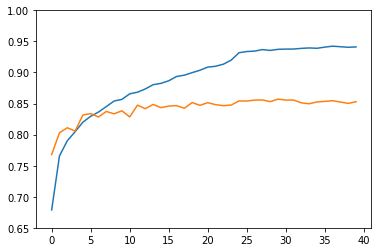

In [23]:
plt.plot(history.history['roc_auc'])
plt.plot(history.history['val_roc_auc'])
plt.ylim(0.65, 1);